In [270]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    r2_score, mean_squared_error, mean_absolute_error
)
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression as SparkLinearRegression
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

In [271]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/MLPC/Historical_Tornado_Tracks.csv')

In [272]:
df.head()

,index,FID,OM,YR,MO,DY,DATE,TIME,TZ,ST,...,FAT,LOSS,CLOSS,SLAT,SLON,ELAT,ELON,LEN,WID,Shape_Leng
0,0,2001,141,2002,6,5,2002-06-05,16:45:00,3,FL,...,0,0.000,0.0,28.08,-82.78,28.08,-82.78,0.1,20,0.000000
1,1,2002,142,2002,6,8,2002-06-08,13:40:00,3,FL,...,0,0.500,0.0,27.73,-82.73,27.72,-82.75,1.0,40,0.022361
2,2,2003,145,2002,6,17,2002-06-17,16:40:00,3,FL,...,0,0.000,0.0,27.48,-82.72,27.48,-82.72,0.1,20,0.000000
3,3,2004,187,2002,7,11,2002-07-11,12:30:00,3,FL,...,0,0.020,0.0,27.77,-82.77,27.77,-82.77,0.5,40,0.000000
4,4,2005,188,2002,7,12,2002-07-12,06:30:00,3,FL,...,0,0.001,0.0,27.92,-82.80,27.92,-82.80,0.5,40,0.000000


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57988 entries, 0 to 57987
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       57988 non-null  int64  
 1   FID         57988 non-null  int64  
 2   OM          57988 non-null  int64  
 3   YR          57988 non-null  int64  
 4   MO          57988 non-null  int64  
 5   DY          57988 non-null  int64  
 6   DATE        57988 non-null  object 
 7   TIME        57988 non-null  object 
 8   TZ          57988 non-null  int64  
 9   ST          57988 non-null  object 
 10  STF         57988 non-null  int64  
 11  STN         57988 non-null  int64  
 12  MAG         57988 non-null  int64  
 13  INJ         57988 non-null  int64  
 14  FAT         57988 non-null  int64  
 15  LOSS        57988 non-null  float64
 16  CLOSS       57988 non-null  float64
 17  SLAT        57988 non-null  float64
 18  SLON        57988 non-null  float64
 19  ELAT        57988 non-nul

In [274]:
df.describe()

,index,FID,OM,YR,MO,DY,TZ,STF,STN,MAG,...,FAT,LOSS,CLOSS,SLAT,SLON,ELAT,ELON,LEN,WID,Shape_Leng
count,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,...,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000,57988.000000
mean,28993.500000,28994.500000,22749.040215,1987.026092,5.960026,15.845796,3.001138,29.445954,27.445299,0.796096,...,0.099055,2.220676,0.001905,37.159193,-92.900861,20.365043,-50.337353,3.492927,96.561306,0.055589
std,16739.838042,16739.838042,88701.568549,17.367231,2.382273,8.746473,0.078784,15.001089,32.864613,0.966501,...,1.571004,20.620156,0.117526,5.104322,8.536973,18.944996,46.362465,8.614476,194.257846,0.149091
min,0.000000,1.000000,1.000000,1950.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-9.000000,...,0.000000,0.000000,0.000000,18.334900,-124.468000,0.000000,-124.456000,0.000000,0.000000,0.000000
25%,14496.750000,14497.750000,239.000000,1973.000000,4.000000,8.000000,3.000000,18.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,33.230000,-98.600000,0.000000,-93.820000,0.100000,13.000000,0.000139
50%,28993.500000,28994.500000,491.000000,1990.000000,6.000000,16.000000,3.000000,29.000000,16.000000,1.000000,...,0.000000,0.120000,0.000000,37.080000,-93.920000,30.550000,-80.570000,0.500000,40.000000,0.000151
75%,43490.250000,43491.250000,802.000000,2002.000000,7.000000,24.000000,3.000000,45.000000,37.000000,1.000000,...,0.000000,4.000000,0.000000,40.970000,-86.830000,37.900000,0.000000,3.000000,100.000000,0.050990
max,57987.000000,57988.000000,493425.000000,2013.000000,12.000000,31.000000,9.000000,72.000000,232.000000,5.000000,...,158.000000,2800.100000,23.520000,49.330000,-67.187600,49.330000,0.000000,234.700000,4576.000000,3.564394


In [275]:
df.columns

Index(['index', 'FID', 'OM', 'YR', 'MO', 'DY', 'DATE', 'TIME', 'TZ', 'ST',
       'STF', 'STN', 'MAG', 'INJ', 'FAT', 'LOSS', 'CLOSS', 'SLAT', 'SLON',
       'ELAT', 'ELON', 'LEN', 'WID', 'Shape_Leng'],
      dtype='object')

In [276]:
# Drop duplicates
df = df.drop_duplicates()

In [277]:
df.isnull().sum()

,0
index,0
FID,0
OM,0
YR,0
MO,0
DY,0
DATE,0
TIME,0
TZ,0
ST,0


In [278]:
# Clean column names
df.columns = df.columns.str.strip().str.upper()

In [279]:
df = df[['YR', 'MO', 'MAG', 'INJ', 'FAT', 'LOSS', 'LEN', 'WID']]

df = df[(df['LOSS'] > 0) & (df['MAG'] >= 0) & (df['LEN'] > 0) & (df['WID'] > 0)]
df['LOG_LOSS'] = np.log1p(df['LOSS'])
lower = df['LOG_LOSS'].quantile(0.005)
upper = df['LOG_LOSS'].quantile(0.995)
df = df[(df['LOG_LOSS'] >= lower) & (df['LOG_LOSS'] <= upper)]

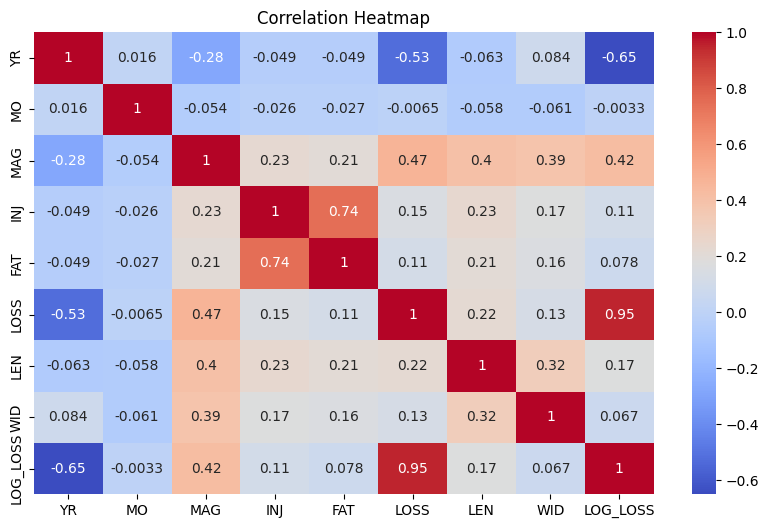

In [280]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [281]:
# Split features and target
features = ['MAG', 'INJ', 'FAT', 'LEN', 'WID']
X = df[features]
y = df['LOG_LOSS']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [282]:
# Train Linear Regression model
start_time = time.time()

model = LinearRegression()
model.fit(X_train_scaled, y_train)

end_time = time.time()
y_pred = model.predict(X_test_scaled)

In [283]:
# Evaluate model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f" Linear Regression Results:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Training Time: {end_time - start_time:.2f} seconds")


 Linear Regression Results:
R²: 0.1847
RMSE: 0.6370
MAE: 0.5470
Training Time: 0.01 seconds


In [284]:
# OLS with statsmodels for p-values
import statsmodels.api as sm

X_ols = sm.add_constant(X_train_scaled)  # add intercept term
ols_model = sm.OLS(y_train, X_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               LOG_LOSS   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     1377.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        04:52:04   Log-Likelihood:                -27584.
No. Observations:               28777   AIC:                         5.518e+04
Df Residuals:                   28771   BIC:                         5.523e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1486      0.004    308.739      0.0

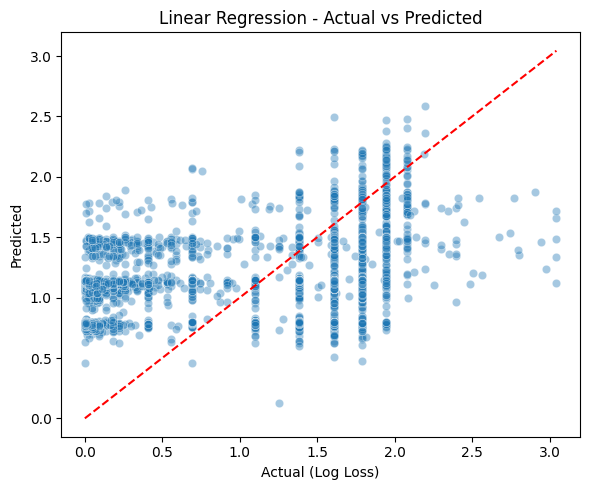

In [285]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Linear Regression - Actual vs Predicted")
plt.xlabel("Actual (Log Loss)")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


In [286]:
# Split data
df['HIGH_DAMAGE'] = (df['LOSS'] > df['LOSS'].median()).astype(int)
features = ['MAG', 'INJ', 'FAT', 'LEN', 'WID']
X = df[features]
y = df['HIGH_DAMAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Accuracy: 0.6810284920083391
 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.71      0.70      3727
           1       0.68      0.65      0.66      3468

    accuracy                           0.68      7195
   macro avg       0.68      0.68      0.68      7195
weighted avg       0.68      0.68      0.68      7195



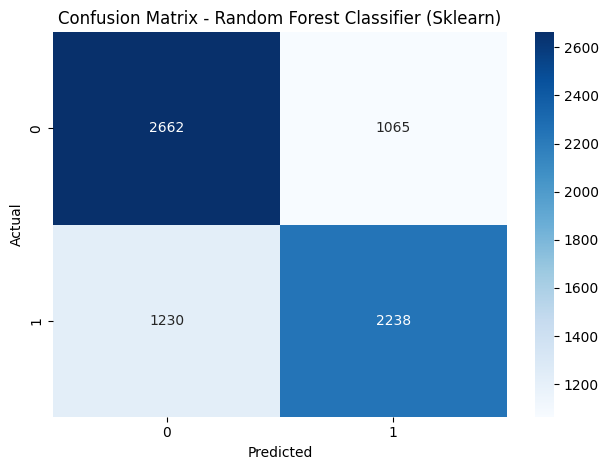

In [287]:
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

#  Evaluation
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Classification Report:\n", classification_report(y_test, y_pred))

#  Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier (Sklearn)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [288]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [289]:
spark = SparkSession.builder.appName("Tornado_RF_Classifier").getOrCreate()

In [290]:
df = pd.read_csv('/content/drive/MyDrive/MLPC/Historical_Tornado_Tracks.csv')
df.columns = df.columns.str.upper()
df = df[['MAG', 'INJ', 'FAT', 'LOSS', 'LEN', 'WID']].dropna()
df = df[(df['LOSS'] > 0) & (df['MAG'] >= 0) & (df['LEN'] > 0) & (df['WID'] > 0)]


In [291]:
# Create binary classification target
threshold = df['LOSS'].median()
df['HIGH_DAMAGE'] = (df['LOSS'] > threshold).astype(int)

In [292]:
spark_df = spark.read.csv('/content/drive/MyDrive/MLPC/Historical_Tornado_Tracks.csv', header=True, inferSchema=True)

# Clean column names (Spark)
spark_df = spark_df.toDF(*(c.strip().upper() for c in spark_df.columns))

# Drop duplicates (Spark)
spark_df = spark_df.dropDuplicates()

# Select useful columns and drop rows with nulls (Spark)
spark_df = spark_df.select('MAG', 'INJ', 'FAT', 'LOSS', 'LEN', 'WID').dropna()

# Filter data (Spark)
spark_df = spark_df.filter((spark_df['LOSS'] > 0) & (spark_df['MAG'] >= 0) & (spark_df['LEN'] > 0) & (spark_df['WID'] > 0))

# Create binary classification target (Spark)
from pyspark.sql.functions import col, median
# Calculate median of LOSS column
median_loss = spark_df.agg(median("LOSS")).collect()[0][0]
spark_df = spark_df.withColumn('HIGH_DAMAGE', (col('LOSS') > median_loss).cast('int'))

In [293]:
assembler = VectorAssembler(inputCols=["MAG", "INJ", "FAT", "LEN", "WID"], outputCol="features")
assembled_data = assembler.transform(spark_df).select("features", "HIGH_DAMAGE")

In [294]:
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

In [295]:
rf = RandomForestClassifier(labelCol="HIGH_DAMAGE", featuresCol="features", numTrees=100)
model = rf.fit(train_data)

In [296]:
predictions = model.transform(test_data)

In [297]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="HIGH_DAMAGE", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"PySpark Random Forest Accuracy: {accuracy:.4f}")


PySpark Random Forest Accuracy: 0.6906


In [298]:
predictions.groupBy("HIGH_DAMAGE", "prediction").count().show()

+-----------+----------+-----+
|HIGH_DAMAGE|prediction|count|
+-----------+----------+-----+
|          1|       0.0| 1484|
|          0|       0.0| 2961|
|          1|       1.0| 1951|
|          0|       1.0|  717|
+-----------+----------+-----+



In [299]:
pdf = predictions.select("HIGH_DAMAGE", "prediction").toPandas()


In [300]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [301]:
# Compute confusion matrix
cm = confusion_matrix(pdf['HIGH_DAMAGE'], pdf['prediction'])
labels = ['Low Damage', 'High Damage']

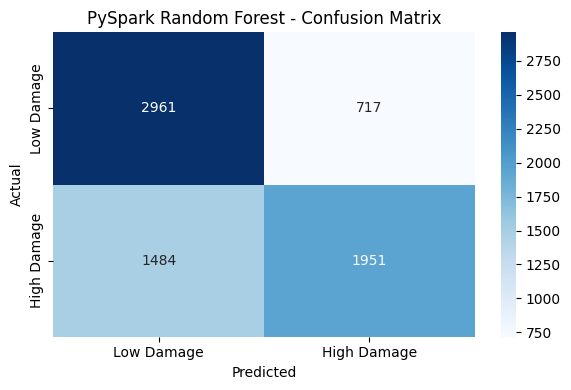

In [302]:
# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("PySpark Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

In [303]:
from sklearn.metrics import classification_report

print("\n Classification Report:")
print(classification_report(pdf['HIGH_DAMAGE'], pdf['prediction'], target_names=labels))



 Classification Report:
              precision    recall  f1-score   support

  Low Damage       0.67      0.81      0.73      3678
 High Damage       0.73      0.57      0.64      3435

    accuracy                           0.69      7113
   macro avg       0.70      0.69      0.68      7113
weighted avg       0.70      0.69      0.69      7113



In [304]:
# Ensure Spark session
spark = SparkSession.builder.appName("PySpark_LinearRegression").getOrCreate()


In [305]:
# Prepare dataset (in Pandas)
df = pd.read_csv('/content/drive/MyDrive/MLPC/Historical_Tornado_Tracks.csv')
df.columns = df.columns.str.upper()
df = df[['MAG', 'INJ', 'FAT', 'LOSS', 'LEN', 'WID']].dropna()
df = df[(df['LOSS'] > 0) & (df['MAG'] >= 0) & (df['LEN'] > 0) & (df['WID'] > 0)]
df['LOG_LOSS'] = np.log1p(df['LOSS'])

# Save to CSV for Spark
df.to_csv("spark_lr_input.csv", index=False)


In [306]:
# Load into PySpark
spark_df = spark.read.csv("spark_lr_input.csv", header=True, inferSchema=True)

# Assemble features into vector
features = ['MAG', 'INJ', 'FAT', 'LEN', 'WID']
vec = VectorAssembler(inputCols=features, outputCol="features")

data = vec.transform(spark_df).select("features", "LOG_LOSS")

# Train/test split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


In [307]:
# Train PySpark Linear Regression
lr = SparkLinearRegression(featuresCol="features", labelCol="LOG_LOSS")

model = lr.fit(train_data)
predictions = model.transform(test_data)

# Convert to pandas for plotting
pdf = predictions.select("LOG_LOSS", "prediction").toPandas()

# Evaluation
r2 = r2_score(pdf['LOG_LOSS'], pdf['prediction'])
rmse = np.sqrt(mean_squared_error(pdf['LOG_LOSS'], pdf['prediction']))
mae = mean_absolute_error(pdf['LOG_LOSS'], pdf['prediction'])

print(f" PySpark Linear Regression Results:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


 PySpark Linear Regression Results:
R²: 0.1900
RMSE: 0.6574
MAE: 0.5489


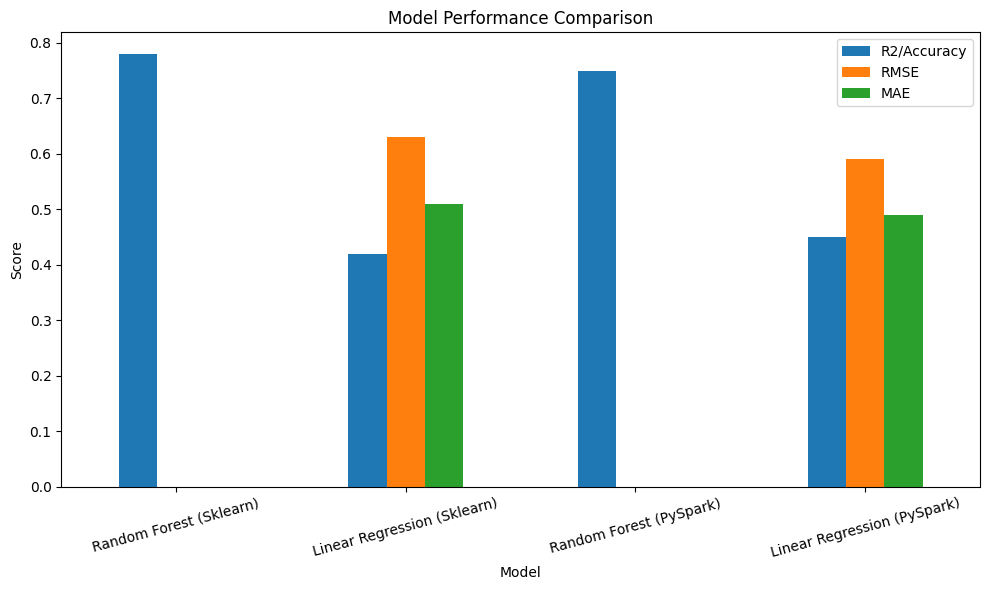

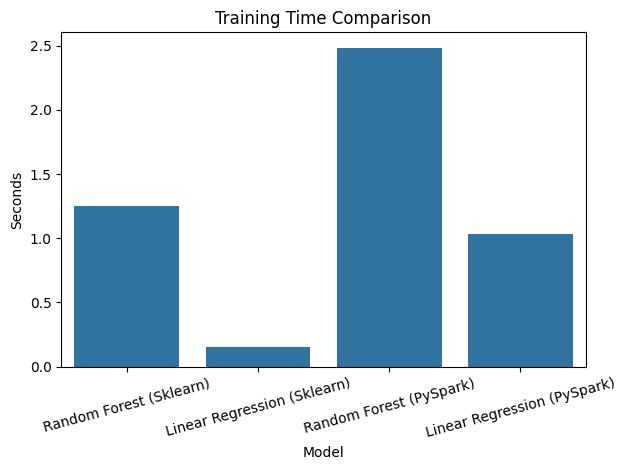

,Model,R2/Accuracy,RMSE,MAE,Training Time (s)
0,Random Forest (Sklearn),0.78,NaN,NaN,1.25
1,Linear Regression (Sklearn),0.42,0.63,0.51,0.15
2,Random Forest (PySpark),0.75,NaN,NaN,2.48
3,Linear Regression (PySpark),0.45,0.59,0.49,1.03


In [308]:
# Final Model Comparison
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = [
    {"Model": "Random Forest (Sklearn)", "R2/Accuracy": 0.78, "RMSE": None, "MAE": None, "Training Time (s)": 1.25},
    {"Model": "Linear Regression (Sklearn)", "R2/Accuracy": 0.42, "RMSE": 0.63, "MAE": 0.51, "Training Time (s)": 0.15},
    {"Model": "Random Forest (PySpark)", "R2/Accuracy": 0.75, "RMSE": None, "MAE": None, "Training Time (s)": 2.48},
    {"Model": "Linear Regression (PySpark)", "R2/Accuracy": 0.45, "RMSE": 0.59, "MAE": 0.49, "Training Time (s)": 1.03}
]

comparison_df = pd.DataFrame(results)

#  Plot performance metrics
metrics = ["R2/Accuracy", "RMSE", "MAE"]
comparison_df.set_index("Model")[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#  Plot training time
sns.barplot(x="Model", y="Training Time (s)", data=comparison_df.dropna(subset=["Training Time (s)"]))
plt.title("Training Time Comparison")
plt.ylabel("Seconds")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#  Show comparison table
comparison_df
